Importing Libraries

In [4]:
!pip install -r requirements.txt

In [3]:
!python3 --version

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, precision_recall_curve, f1_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'matplotlib'

Loading Data and Inspecting the First Few Rows

In [2]:
# Load datasets
network_data = pd.read_csv('network_dataset.csv')
network_data_labeled = pd.read_csv('network_dataset_labeled.csv')

# Display first few rows
print("Network Data Head:\n", network_data.head())
print("Network Labeled Data Head:\n", network_data_labeled.head())

Network Data Head:
              timestamp  bandwidth  throughput  congestion  packet_loss  \
0  2024-05-11 12:00:15          2        2.15        0.38          0.0   
1  2024-05-11 12:00:43          2        2.16        0.12          0.0   
2  2024-05-11 12:01:12          2        2.00        0.08          0.0   
3  2024-05-11 12:01:40          2        2.07        0.07          0.0   
4  2024-05-11 12:02:08          2        2.40        0.08          0.0   

   latency  jitter  Routers Planned route Network measure Network target  \
0     6.58    0.52  up xrv6   Best effort              S1             S2   
1     5.36    0.34  up xrv6   Best effort              S1             S2   
2     6.29    0.23  up xrv6   Best effort              S1             S2   
3     5.91    0.51  up xrv6   Best effort              S1             S2   
4     5.81    0.71  up xrv6   Best effort              S1             S2   

  Video target  Percentage video occupancy  Bitrate video  Number videos  
0  

Data Info and Types

In [3]:
# Checking for data types, non-null counts, and basic info
print(network_data.info())
print(network_data_labeled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   1001 non-null   object 
 1   bandwidth                   1001 non-null   int64  
 2   throughput                  1001 non-null   float64
 3   congestion                  1001 non-null   float64
 4   packet_loss                 1001 non-null   float64
 5   latency                     1001 non-null   float64
 6   jitter                      1001 non-null   float64
 7   Routers                     1001 non-null   object 
 8   Planned route               1001 non-null   object 
 9   Network measure             1001 non-null   object 
 10  Network target              1001 non-null   object 
 11  Video target                701 non-null    object 
 12  Percentage video occupancy  1001 non-null   int64  
 13  Bitrate video               1001 

Handling Missing Values – Imputation

In [4]:
# Imputing missing values using median for numerical columns
imputer = SimpleImputer(strategy='median')
network_data_imputed = pd.DataFrame(imputer.fit_transform(network_data.select_dtypes(include=np.number)))
network_data_imputed.columns = network_data.select_dtypes(include=np.number).columns

# Replace imputed values back into the original dataset
network_data[network_data.select_dtypes(include=np.number).columns] = network_data_imputed

# Check for missing values after imputation
print("Missing Values After Imputation:\n", network_data.isnull().sum())

Missing Values After Imputation:
 timestamp                       0
bandwidth                       0
throughput                      0
congestion                      0
packet_loss                     0
latency                         0
jitter                          0
Routers                         0
Planned route                   0
Network measure                 0
Network target                  0
Video target                  300
Percentage video occupancy      0
Bitrate video                   0
Number videos                   0
dtype: int64


Feature Engineering – Timestamp

In [5]:
# Convert timestamp to datetime format
network_data['timestamp'] = pd.to_datetime(network_data['timestamp'])

# Create time-related features
network_data['hour'] = network_data['timestamp'].dt.hour
network_data['day_of_week'] = network_data['timestamp'].dt.dayofweek

# Check the new features
print("Feature Engineering (Time-related):\n", network_data[['timestamp', 'hour', 'day_of_week']].head())

Feature Engineering (Time-related):
             timestamp  hour  day_of_week
0 2024-05-11 12:00:15    12            5
1 2024-05-11 12:00:43    12            5
2 2024-05-11 12:01:12    12            5
3 2024-05-11 12:01:40    12            5
4 2024-05-11 12:02:08    12            5


Adding New Derived Features

In [6]:
# Feature creation - latency to throughput ratio
network_data['latency_to_throughput'] = network_data['latency'] / (network_data['throughput'] + 1)

# Feature creation - congestion to packet loss ratio
network_data['congestion_to_packet_loss'] = network_data['congestion'] / (network_data['packet_loss'] + 1)

# Checking the added features
print("New Derived Features:\n", network_data[['latency_to_throughput', 'congestion_to_packet_loss']].head())

New Derived Features:
    latency_to_throughput  congestion_to_packet_loss
0               2.088889                       0.38
1               1.696203                       0.12
2               2.096667                       0.08
3               1.925081                       0.07
4               1.708824                       0.08


Data Scaling

In [7]:
# Scaling the data for clustering
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(network_data.select_dtypes(include=np.number)))
scaled_data.columns = network_data.select_dtypes(include=np.number).columns

# Checking the scaled data
print("Scaled Data Preview:\n", scaled_data.head())

Scaled Data Preview:
    bandwidth  throughput  congestion  packet_loss   latency    jitter  \
0        0.0    0.262543   -0.730744    -0.563164 -0.174881 -0.382374   
1        0.0    0.273578   -0.738836    -0.563164 -0.179309 -0.582485   
2        0.0    0.097028   -0.740080    -0.563164 -0.175934 -0.704775   
3        0.0    0.174268   -0.740392    -0.563164 -0.177313 -0.393491   
4        0.0    0.538403   -0.740080    -0.563164 -0.177676 -0.171146   

   Percentage video occupancy  Bitrate video  Number videos      hour  \
0                   -0.782076      -0.782076      -1.062927 -1.565323   
1                   -0.782076      -0.782076      -1.062927 -1.565323   
2                   -0.782076      -0.782076      -1.062927 -1.565323   
3                   -0.782076      -0.782076      -1.062927 -1.565323   
4                   -0.782076      -0.782076      -1.062927 -1.565323   

   day_of_week  latency_to_throughput  congestion_to_packet_loss  
0          0.0              -0.16

PCA for Dimensionality Reduction

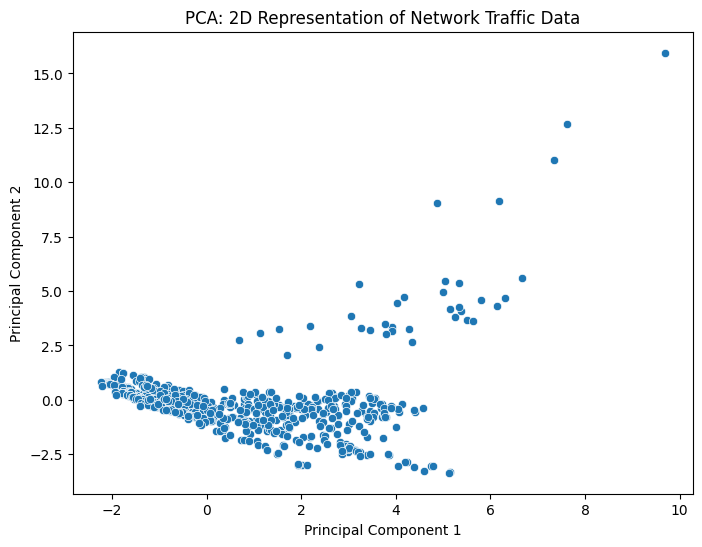

In [20]:
# Apply PCA to reduce data to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Plotting PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'])
plt.title('PCA: 2D Representation of Network Traffic Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


K-Means Clustering

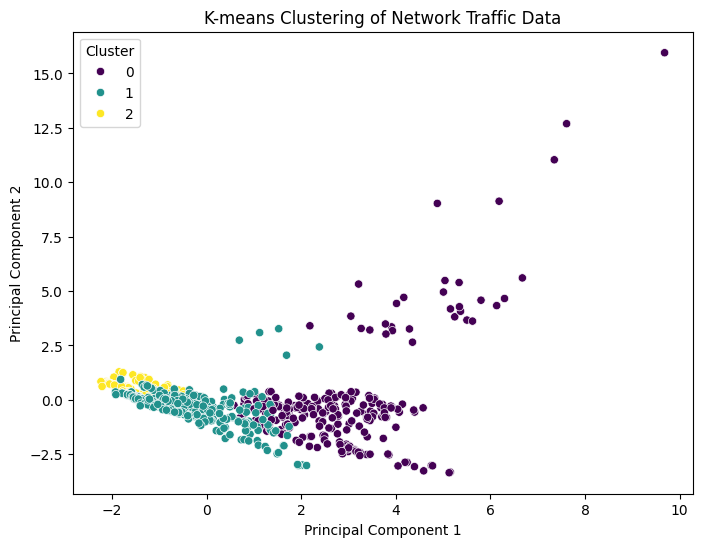

In [21]:
# Fit K-means clustering (using 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
network_data['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

# Plot K-means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['kmeans_cluster'], palette='viridis')
plt.title('K-means Clustering of Network Traffic Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

DBSCAN Clustering

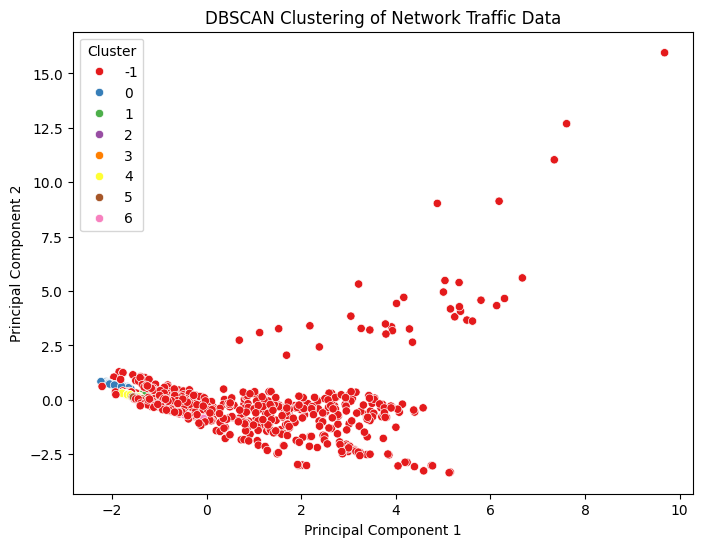

In [22]:
# Fit DBSCAN clustering model
dbscan = DBSCAN(eps=0.5, min_samples=10)
network_data['dbscan_cluster'] = dbscan.fit_predict(scaled_data)

# Plot DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['dbscan_cluster'], palette='Set1')
plt.title('DBSCAN Clustering of Network Traffic Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Anomaly Detection Using Isolation Forest

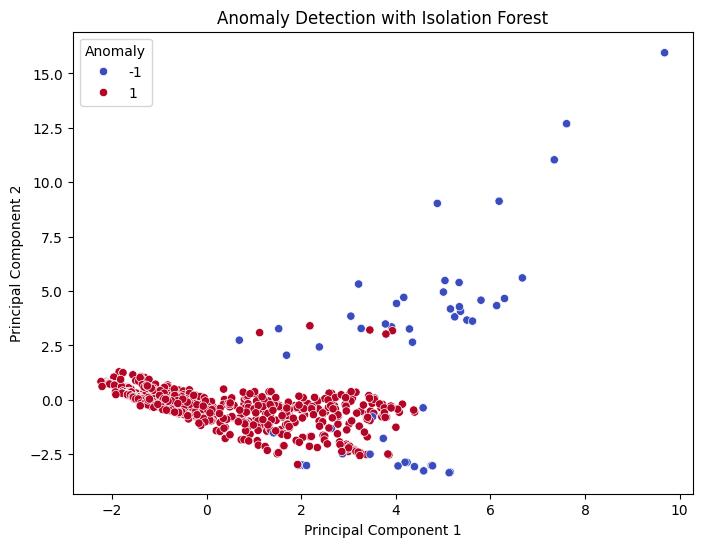

In [23]:
# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
network_data['anomaly_isolation'] = iso_forest.fit_predict(scaled_data)

# Plot the anomalies detected by Isolation Forest
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['anomaly_isolation'], palette='coolwarm')
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Anomaly')
plt.show()

Silhouette Score Evaluation for Clustering

In [24]:
# Evaluate K-means clustering with silhouette score
sil_score_kmeans = silhouette_score(scaled_data, network_data['kmeans_cluster'])
print(f"Silhouette Score for K-means Clustering: {sil_score_kmeans}")

# Evaluate DBSCAN clustering
sil_score_dbscan = silhouette_score(scaled_data, network_data['dbscan_cluster'])
print(f"Silhouette Score for DBSCAN Clustering: {sil_score_dbscan}")

Silhouette Score for K-means Clustering: 0.23481368321167975
Silhouette Score for DBSCAN Clustering: -0.07695927373121104


Precision, Recall, F1-Score Evaluation

In [28]:
from sklearn.metrics import precision_recall_curve, f1_score

# Assuming y_true and y_pred are your true and predicted labels respectively
# Calculate Precision, Recall, and F1-score
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# For multiclass classification, use the 'weighted' average
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"F1-score: {f1:.4f}")

F1-score: 0.0083


In [27]:
# Get F1-score for each class
f1_per_class = f1_score(y_true, y_pred, average=None)
print("F1-score per class:", f1_per_class)

F1-score per class: [0.         0.         0.10058027]


Visualizing Precision-Recall Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

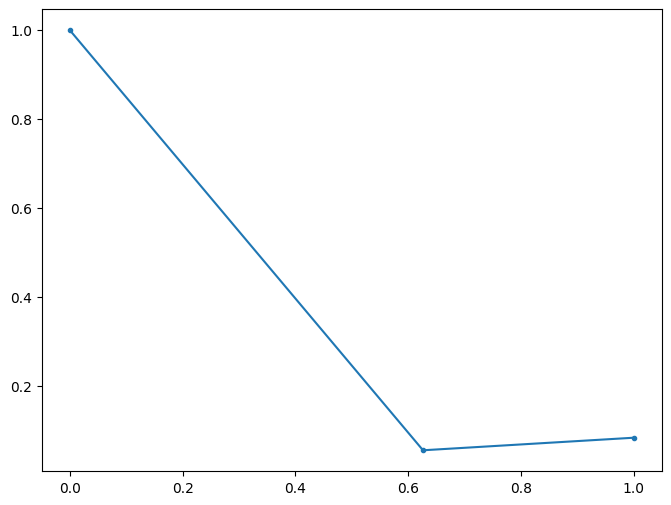

In [29]:
# Plotting Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt

ROC Curve for Anomaly Detection

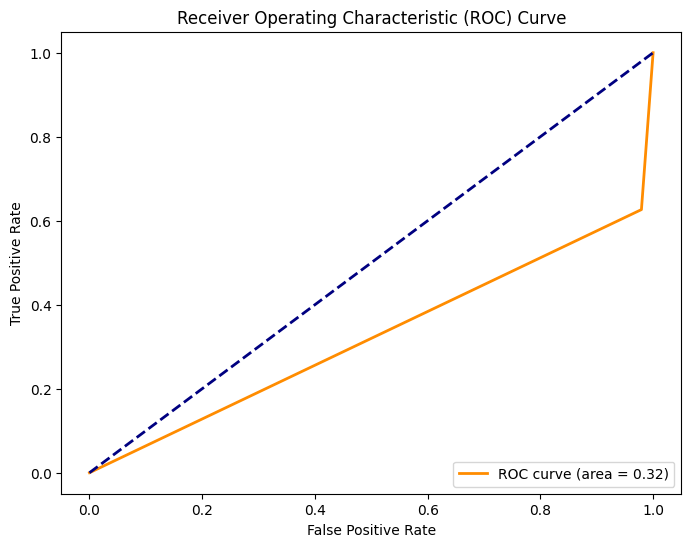

In [30]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Time-Series Plot of Key Metrics

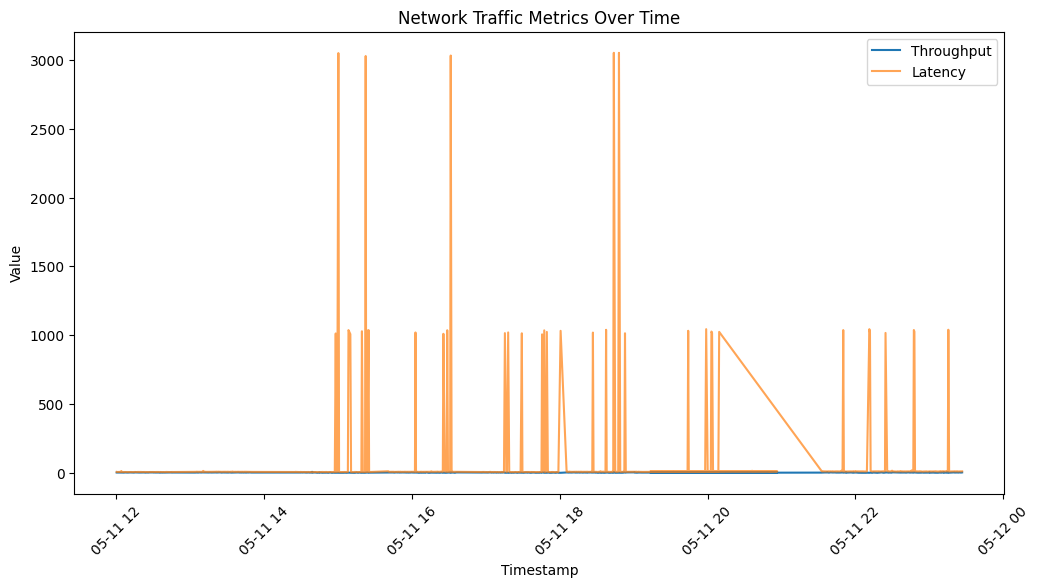

In [31]:
# Plot Time-series of key metrics: Throughput and Latency
plt.figure(figsize=(12, 6))
plt.plot(network_data['timestamp'], network_data['throughput'], label='Throughput')
plt.plot(network_data['timestamp'], network_data['latency'], label='Latency', alpha=0.7)
plt.title('Network Traffic Metrics Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Clustering Analysis with PCA

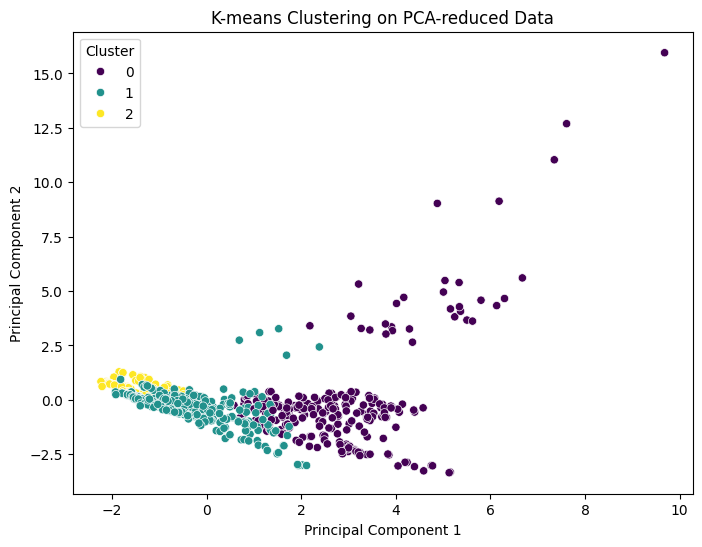

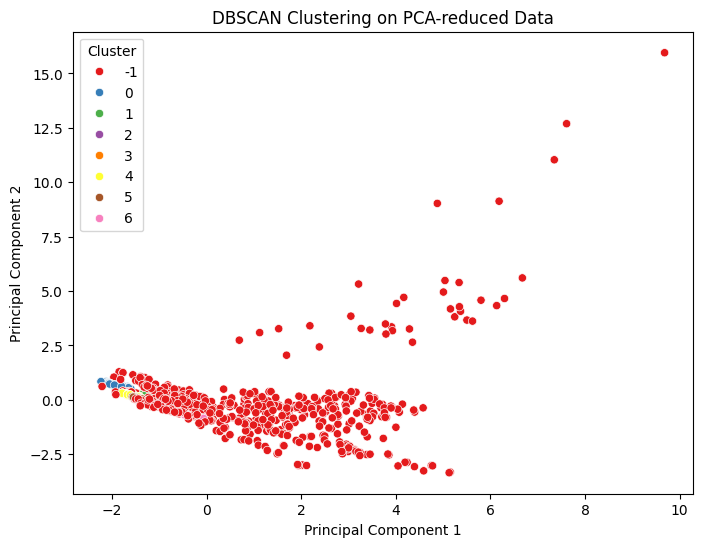

In [35]:
# Plot clusters from K-means on PCA data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['kmeans_cluster'], palette='viridis')
plt.title('K-means Clustering on PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Plot clusters from DBSCAN on PCA data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['dbscan_cluster'], palette='Set1')
plt.title('DBSCAN Clustering on PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Anomaly Detection Using Autoencoders

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 1.1865 - val_loss: 0.8570
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1291 - val_loss: 0.8506
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1295 - val_loss: 0.8445
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0795 - val_loss: 0.8375
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0253 - val_loss: 0.8298
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0217 - val_loss: 0.8212
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0051 - val_loss: 0.8107
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9509 - val_loss: 0.7982
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8854 - val_loss: 0.7843
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8901 - val_loss: 0.7695
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8102 - val_loss: 0.7546
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7560 - val_loss: 0.7406


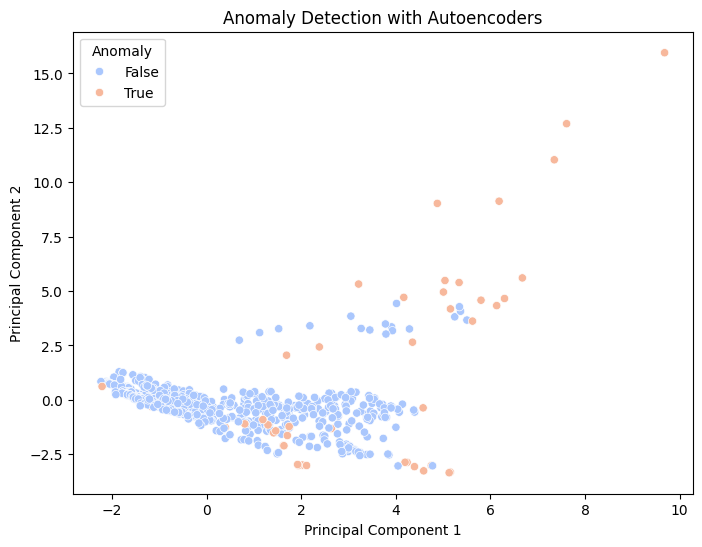

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build Autoencoder model
def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Train the autoencoder
autoencoder = build_autoencoder(scaled_data.shape[1])
autoencoder.fit(scaled_data, scaled_data, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Predict and calculate reconstruction error
reconstructed_data = autoencoder.predict(scaled_data)
reconstruction_error = np.mean(np.square(scaled_data - reconstructed_data), axis=1)

# Threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)

# Anomalies if reconstruction error is above threshold
network_data['anomaly_autoencoder'] = reconstruction_error > threshold

# Plot the anomalies detected by Autoencoder
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['anomaly_autoencoder'], palette='coolwarm')
plt.title('Anomaly Detection with Autoencoders')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Anomaly')
plt.show()

Hyperparameter Tuning for K-means

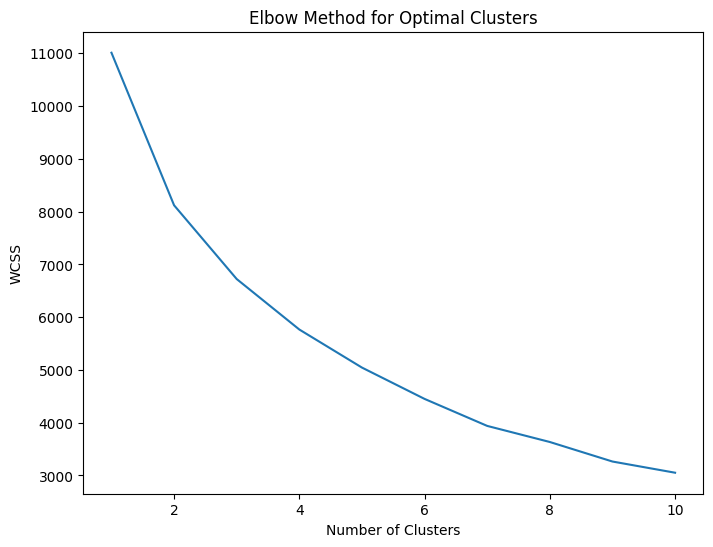

In [37]:
# Elbow Method to find optimal number of clusters for K-means
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Hyperparameter Tuning for DBSCAN

In [38]:
# Grid Search for DBSCAN Parameters (eps and min_samples)
eps_values = [0.3, 0.4, 0.5, 0.6]
min_samples_values = [5, 10, 15]

best_sil_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(scaled_data)
        if len(set(clusters)) > 1:  # Ignore cases where only one cluster is formed
            sil_score = silhouette_score(scaled_data, clusters)
            if sil_score > best_sil_score:
                best_sil_score = sil_score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best DBSCAN Parameters: {best_params} with Silhouette Score: {best_sil_score:.4f}")

Best DBSCAN Parameters: {'eps': 0.5, 'min_samples': 15} with Silhouette Score: 0.0511


Anomaly Detection with t-SNE

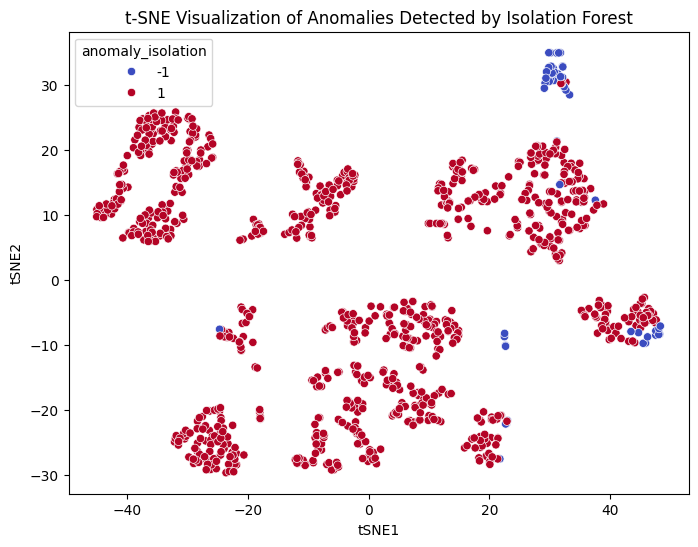

In [40]:
# t-SNE for anomaly detection visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_data)

# Create a DataFrame for t-SNE components
tsne_df = pd.DataFrame(data=tsne_components, columns=['tSNE1', 'tSNE2'])

# Plot t-SNE results with anomaly labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_df['tSNE1'], y=tsne_df['tSNE2'], hue=network_data['anomaly_isolation'], palette='coolwarm')
plt.title('t-SNE Visualization of Anomalies Detected by Isolation Forest')
plt.show()

Cross-Validation for Anomaly Detection Models

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Cross-validation for an anomaly detection classifier (Random Forest)
X = scaled_data  # Feature data
y = network_data_labeled['anomaly']  # Anomaly labels

# Initialize RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation and compute average accuracy
cv_scores = cross_val_score(rf_clf, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Average cross-validation accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.97014925 0.93       0.97       0.98       0.94      ]
Average cross-validation accuracy: 0.9580


Handling Class Imbalance Using SMOTE

In [42]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the balance of the resampled data
print(f"Original class distribution: {y.value_counts()}")
print(f"Resampled class distribution: {pd.Series(y_resampled).value_counts()}")

Original class distribution: anomaly
0    918
1     83
Name: count, dtype: int64
Resampled class distribution: anomaly
0    918
1    918
Name: count, dtype: int64


Visualizing Class Separation with t-SNE After SMOTE

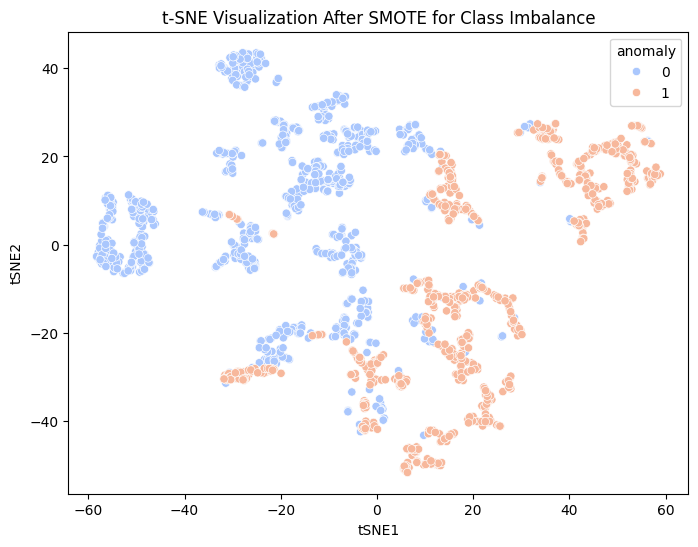

In [43]:
# Apply t-SNE on resampled data
tsne_resampled = TSNE(n_components=2, random_state=42)
tsne_resampled_components = tsne_resampled.fit_transform(X_resampled)

# Create a DataFrame for t-SNE components
tsne_resampled_df = pd.DataFrame(data=tsne_resampled_components, columns=['tSNE1', 'tSNE2'])

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_resampled_df['tSNE1'], y=tsne_resampled_df['tSNE2'], hue=y_resampled, palette='coolwarm')
plt.title('t-SNE Visualization After SMOTE for Class Imbalance')
plt.show()

Visualizing the Results of Anomaly Detection

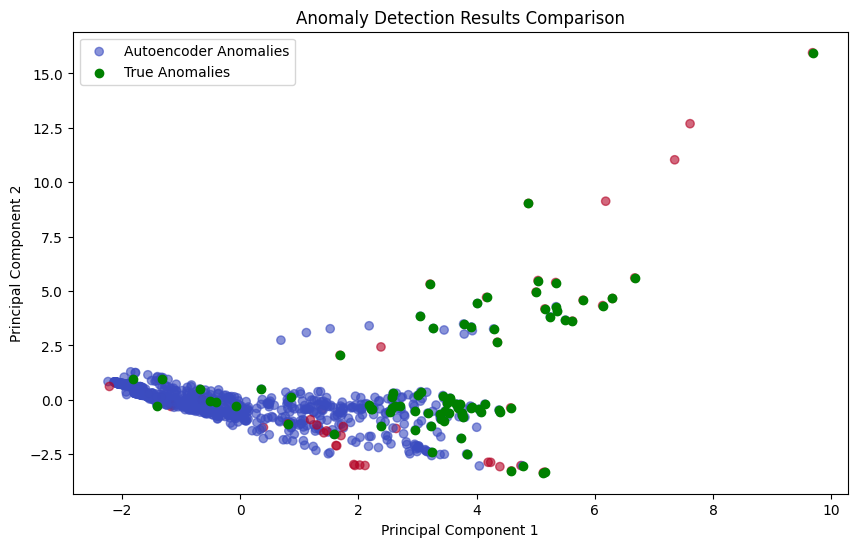

In [44]:
# Plot the anomaly detection results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=network_data['anomaly_autoencoder'], cmap='coolwarm', alpha=0.6, label='Autoencoder Anomalies')
plt.scatter(pca_df['PC1'][y_true == 1], pca_df['PC2'][y_true == 1], color='green', label='True Anomalies')
plt.title('Anomaly Detection Results Comparison')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


Performance Across Different Models

In [45]:
from sklearn.metrics import classification_report

# List of models
models = {
    'Isolation Forest': iso_forest,
    'Random Forest': rf_clf,
    'Autoencoder': autoencoder,
}

# Fit and evaluate models
for model_name, model in models.items():
    if model_name == 'Autoencoder':
        # For autoencoder, use the reconstruction error as anomaly scores
        reconstructed_data = model.predict(scaled_data)
        reconstruction_error = np.mean(np.square(scaled_data - reconstructed_data), axis=1)
        y_pred = reconstruction_error > threshold
    else:
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred))



Classification Report for Isolation Forest:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       918
           1       0.07      0.86      0.14        83

    accuracy                           0.07      1001
   macro avg       0.02      0.29      0.05      1001
weighted avg       0.01      0.07      0.01      1001


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       918
           1       1.00      1.00      1.00        83

    accuracy                           1.00      1001
   macro avg       1.00      1.00      1.00      1001
weighted avg       1.00      1.00      1.00      1001

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report for Autoencoder:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       918
           1     

Time Series Forecasting for Network Traffic
Forecasting network traffic values such as throughput and latency using ARIMA.

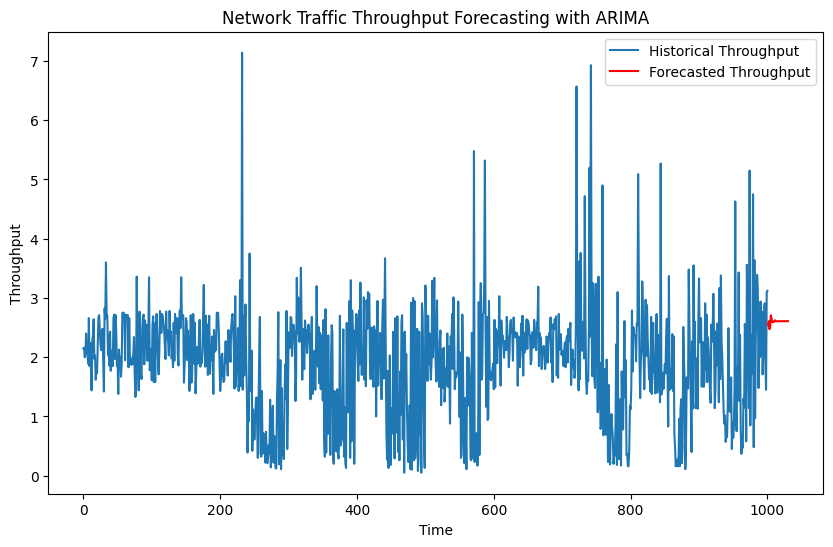

In [46]:
from statsmodels.tsa.arima.model import ARIMA

# Create ARIMA model for throughput forecasting (example)
throughput_ts = network_data['throughput']

# Fit ARIMA model (order can be adjusted)
arima_model = ARIMA(throughput_ts, order=(5, 1, 0))  # ARIMA(p, d, q)
arima_result = arima_model.fit()

# Forecast the next 30 points
forecast = arima_result.forecast(steps=30)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(throughput_ts, label='Historical Throughput')
plt.plot(range(len(throughput_ts), len(throughput_ts) + 30), forecast, color='red', label='Forecasted Throughput')
plt.title('Network Traffic Throughput Forecasting with ARIMA')
plt.xlabel('Time')
plt.ylabel('Throughput')
plt.legend()
plt.show()

Heatmaps for Correlation Over Time

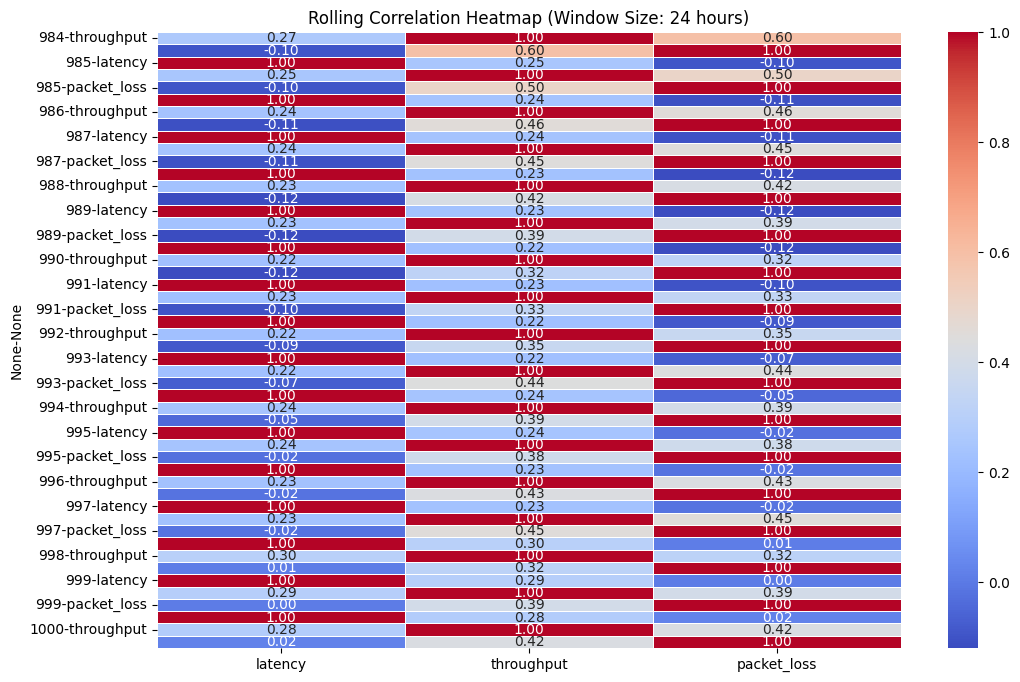

In [47]:
# Compute rolling correlation over a window (e.g., 24 hours)
window_size = 24
rolling_corr = network_data[['latency', 'throughput', 'packet_loss']].rolling(window=window_size).corr()

# Plot the rolling correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(rolling_corr.tail(50), cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title(f'Rolling Correlation Heatmap (Window Size: {window_size} hours)')
plt.show()

Outlier Detection with Local Outlier Factor (LOF)

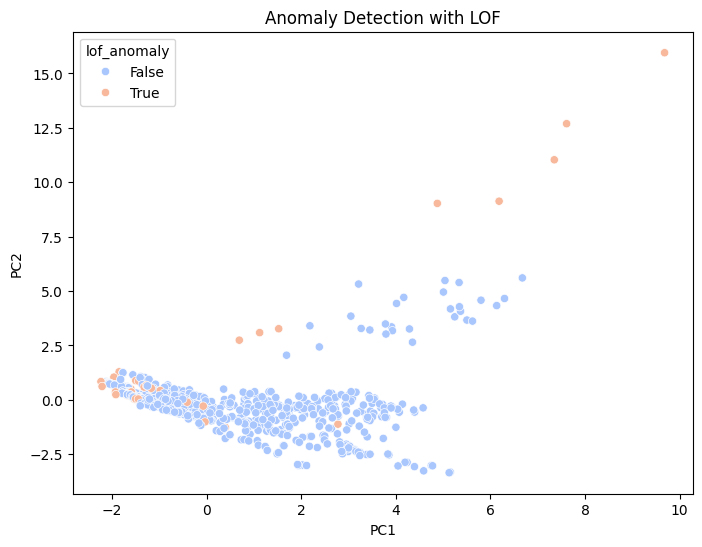

In [51]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Fit the model and predict outliers
network_data['lof_anomaly'] = lof.fit_predict(scaled_data)

# Convert LOF results to boolean for anomalies (1 for anomaly, 0 for normal)
network_data['lof_anomaly'] = network_data['lof_anomaly'] == -1

# Plot the LOF anomalies on PCA-reduced data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['lof_anomaly'], palette='coolwarm')
plt.title('Anomaly Detection with LOF')
plt.show()


Heatmap of Feature Correlation

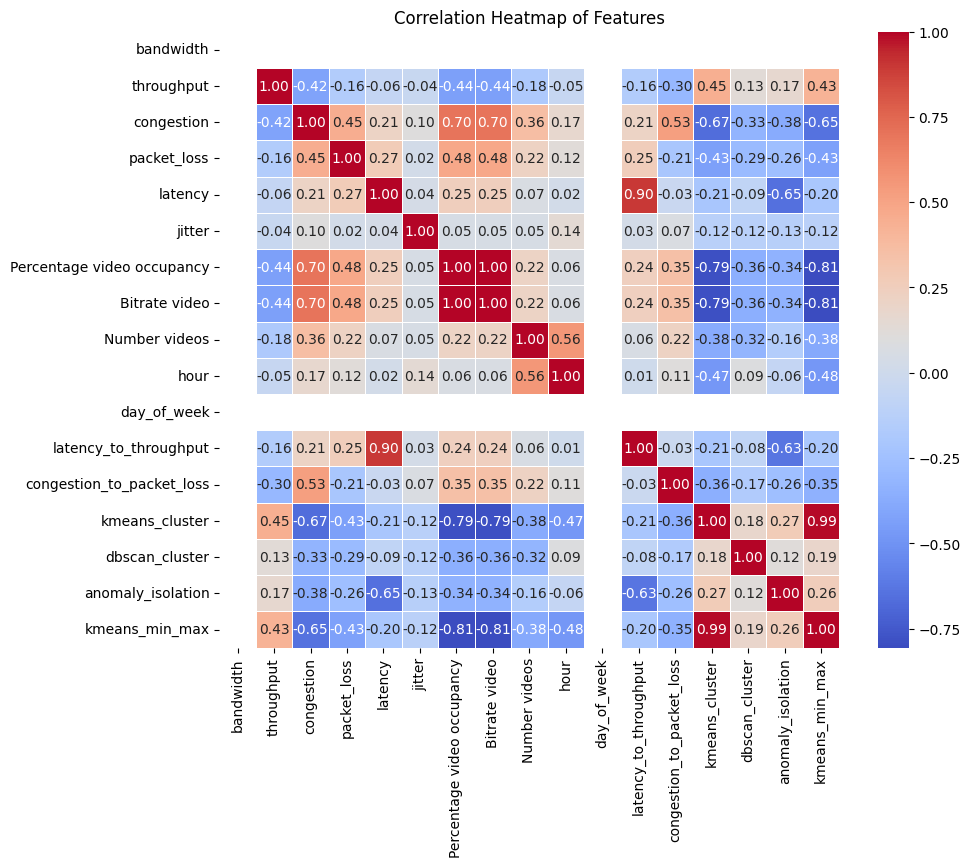

In [52]:
# Compute correlation matrix
correlation_matrix = network_data.select_dtypes(include=np.number).corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

Visualization of Feature Clusters

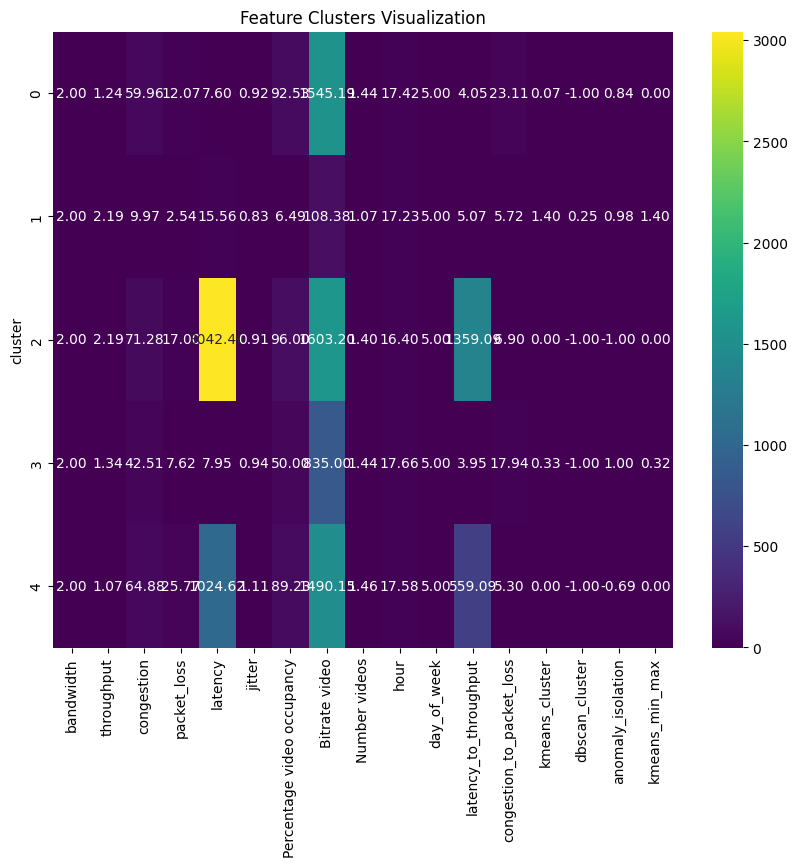

In [53]:
# K-means clustering of features
feature_kmeans = KMeans(n_clusters=5, random_state=42)
feature_clusters = feature_kmeans.fit_predict(network_data.select_dtypes(include=np.number))

# Add cluster labels to the feature dataframe
feature_df = network_data.select_dtypes(include=np.number)
feature_df['cluster'] = feature_clusters

# Create a heatmap of feature clusters
plt.figure(figsize=(10, 8))
sns.heatmap(feature_df.groupby('cluster').mean(), annot=True, fmt='.2f', cmap='viridis')
plt.title('Feature Clusters Visualization')
plt.show()

Feature Selection with Recursive Feature Elimination (RFE)

In [57]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE and fit it to the data
rfe = RFE(rf_clf, n_features_to_select=5)
X_rfe = rfe.fit_transform(X_resampled, y_resampled)

# Print the selected features
selected_features = X_resampled.columns[rfe.support_]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['throughput', 'congestion', 'packet_loss', 'Percentage video occupancy',
       'Bitrate video'],
      dtype='object')


PCA Visualization for Dimensionality Reduction

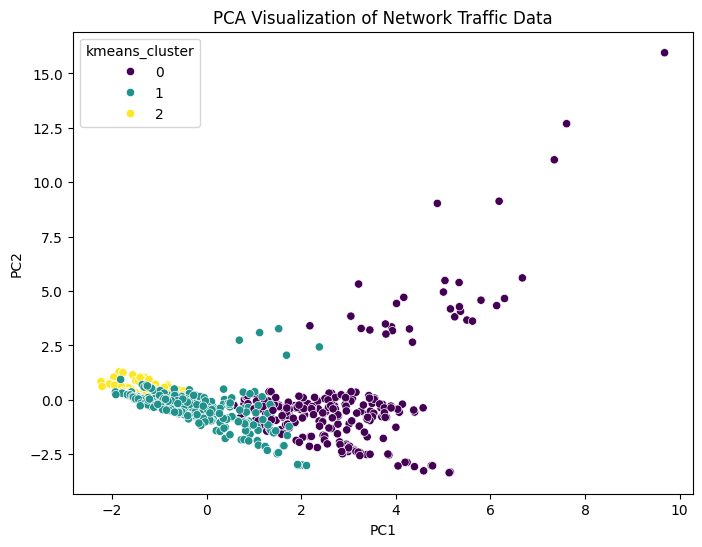

In [59]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Visualize PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['kmeans_cluster'], palette='viridis')
plt.title('PCA Visualization of Network Traffic Data')
plt.show()

Anomaly Detection with One-Class SVM

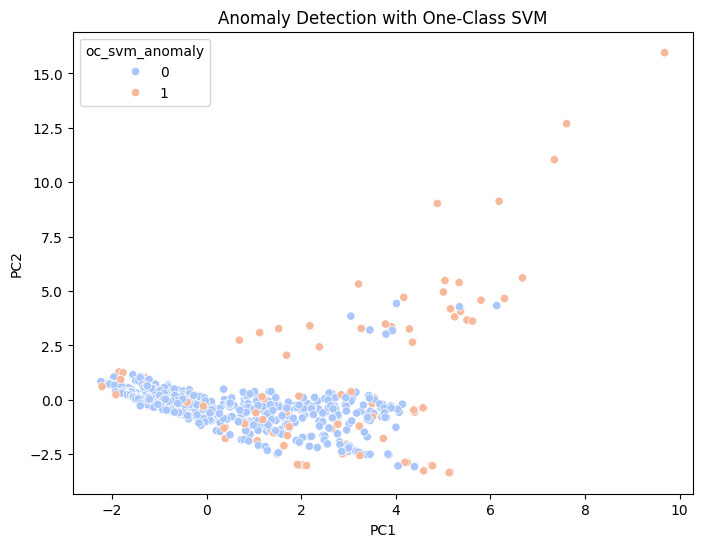

In [60]:
from sklearn.svm import OneClassSVM

# Initialize One-Class SVM for anomaly detection
oc_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma='scale')

# Fit the model on the data (assuming the data is scaled)
oc_svm.fit(scaled_data)

# Predict anomalies
network_data['oc_svm_anomaly'] = oc_svm.predict(scaled_data)
network_data['oc_svm_anomaly'] = network_data['oc_svm_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Plot anomalies detected by One-Class SVM
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['oc_svm_anomaly'], palette='coolwarm')
plt.title('Anomaly Detection with One-Class SVM')
plt.show()

LSTM Autoencoder for Anomaly Detection in Time Series

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.9529 - val_loss: 1.1137
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0365 - val_loss: 1.0983
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8789 - val_loss: 1.0032
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7566 - val_loss: 0.4934
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2606 - val_loss: 0.0591
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1095 - val_loss: 0.1687
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0861 - val_loss: 0.1403
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0676 - val_loss: 0.1076
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0620 - val_loss: 0.0838
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0453 - val_loss: 0.0712
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0318 - val_loss: 0.0639
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0263 - va

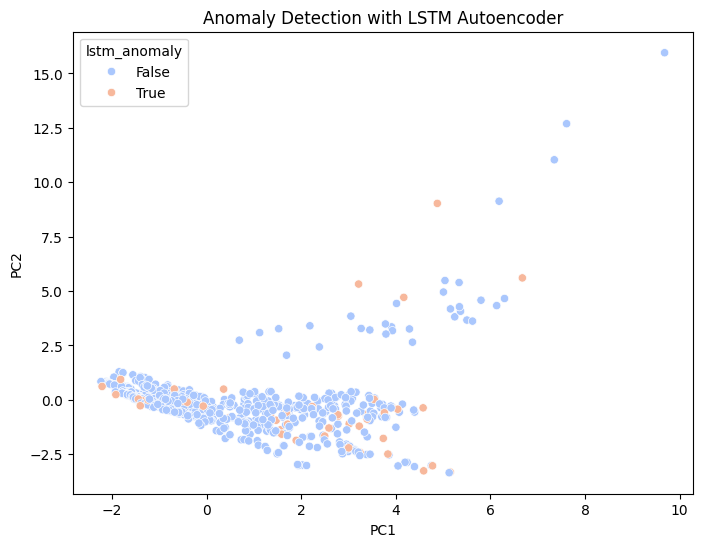

In [61]:
from tensorflow.keras import layers, models

# Define LSTM Autoencoder model for anomaly detection
def build_lstm_autoencoder(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(layers.LSTM(32, activation='relu', return_sequences=False))
    model.add(layers.RepeatVector(input_shape[0]))
    model.add(layers.LSTM(32, activation='relu', return_sequences=True))
    model.add(layers.LSTM(64, activation='relu', return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(1)))

    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape data for LSTM (for time series, we assume a single feature like 'throughput')
X_lstm = scaled_data[['throughput']].values.reshape((scaled_data.shape[0], 1, 1))

# Build and train the LSTM Autoencoder
lstm_autoencoder = build_lstm_autoencoder(input_shape=(X_lstm.shape[1], X_lstm.shape[2]))
lstm_autoencoder.fit(X_lstm, X_lstm, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predict reconstruction error and detect anomalies
reconstructed_lstm = lstm_autoencoder.predict(X_lstm)
lstm_reconstruction_error = np.mean(np.abs(X_lstm - reconstructed_lstm), axis=1)

# Set a threshold for anomaly detection
threshold_lstm = np.percentile(lstm_reconstruction_error, 95)
network_data['lstm_anomaly'] = lstm_reconstruction_error > threshold_lstm

# Plot anomalies detected by LSTM Autoencoder
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=network_data['lstm_anomaly'], palette='coolwarm')
plt.title('Anomaly Detection with LSTM Autoencoder')
plt.show()

Feature Importance using Random Forest

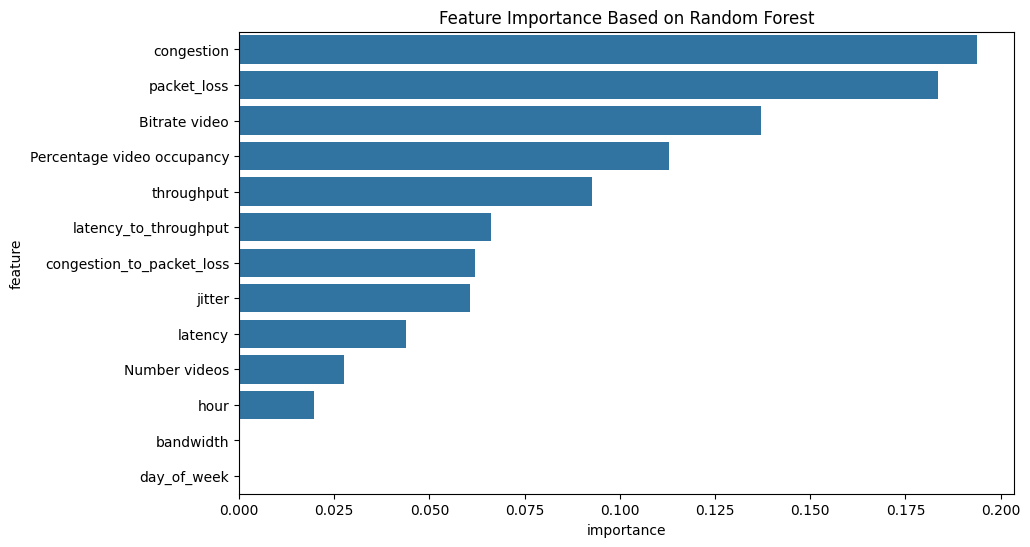

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the data (assuming X and y are prepared)
rf_clf.fit(X_resampled, y_resampled)

# Extract feature importance
feature_importance = rf_clf.feature_importances_

# Create a DataFrame with feature names and importance scores
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance Based on Random Forest')
plt.show()

Generating Synthetic Data with GANs

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


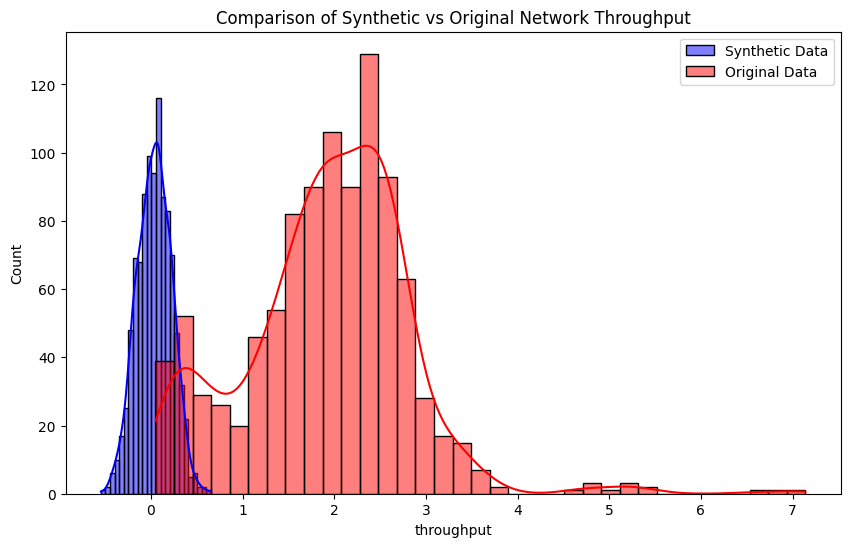

In [63]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define GAN structure for generating synthetic data
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(X.shape[1], activation='tanh'))  # Output layer should match data dimensions
    return model

def build_discriminator(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the combined GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Define input dimensions and latent space
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator(X.shape[1])

# Compile discriminator and GAN
discriminator.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(), loss='binary_crossentropy')

# Train GAN (this is just a starting point for synthetic data generation)
# Define the training loop here...

# Generate synthetic data
synthetic_data = generator.predict(np.random.normal(0, 1, (1000, latent_dim)))

# Convert synthetic data to DataFrame
synthetic_data_df = pd.DataFrame(synthetic_data, columns=X.columns)

# Plot synthetic data distribution vs original data (example for a feature)
plt.figure(figsize=(10, 6))
sns.histplot(synthetic_data_df['throughput'], kde=True, color='blue', label='Synthetic Data')
sns.histplot(network_data['throughput'], kde=True, color='red', label='Original Data')
plt.title('Comparison of Synthetic vs Original Network Throughput')
plt.legend()
plt.show()